# 1. Setup


## 1.1. Import statements

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import os
from torchinfo import summary
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

## 1.2. Device configuration

In [3]:
def get_device():
    """Get the best available device for PyTorch."""
    if torch.cuda.is_available():
        device = "cuda"

        # The flag below controls whether to allow TF32 on matmul.
        torch.backends.cuda.matmul.allow_tf32 = True
        # The flag below controls whether to allow TF32 on cuDNN.
        torch.backends.cudnn.allow_tf16 = True
        # Print GPU info
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
        
        # Set up GPU memory management
        memory_limit_mb = 4095.5  # Adjust as needed
        total_memory = torch.cuda.get_device_properties(0).total_memory
        memory_limit = memory_limit_mb * 1024 ** 2
        memory_fraction = memory_limit / total_memory
        torch.cuda.set_per_process_memory_fraction(memory_fraction, device=0)
        print(f"Set GPU memory fraction to {memory_fraction:.2%}")
        
    elif torch.backends.mps.is_available():
        device = "mps"
        print("Using Apple Silicon MPS device")
    else:
        device = "cpu"
        print("Using CPU device")
    
    return torch.device(device)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

torch.set_float32_matmul_precision('high')

device = get_device()

Using CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Set GPU memory fraction to 100.00%


In [4]:
pin_memory = True if device.type == 'cuda' else False
pin_memory_device = 'cuda' if device.type == 'cuda' else ''

# 2. Load & transform data


## 2.1. Calculate dataset statistics

In [5]:
# First, create transforms without normalization to calculate dataset statistics
initial_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.ToImage(),
    v2.ToDtype(torch.float16, scale=True)
])

In [6]:
label_transforms = v2.Lambda(
    lambda y: torch.zeros(54, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y, dtype=torch.long), value=1)
)

In [7]:
# Create temporary dataset to calculate mean and std
temp_dataset = ImageFolder(root='../data/data_pool', transform=initial_transforms, target_transform=label_transforms)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=pin_memory, pin_memory_device=pin_memory_device)

In [ ]:
calc_stats = True

if calc_stats:
    print(f"Computing dataset statistics using device: {device}")
    print(f"Number of images to process: {len(temp_dataset)}")

    channels_sum = torch.zeros(3, device=device)
    channels_sqrd_sum = torch.zeros(3, device=device)
    num_batches = 0
    start_time = time.time()

    for batch_idx, (data, _) in enumerate(tqdm(temp_loader, desc="Computing mean/std")):
        data = data.to(device)  # Add non_blocking=True
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1
        
        if batch_idx % 10 == 0:
            batch_time = time.time() - start_time
            print(f"\nProcessed {batch_idx * temp_loader.batch_size} images in {batch_time:.2f}s")

    mean = channels_sum / num_batches
    std = torch.sqrt(channels_sqrd_sum / num_batches - mean ** 2)

    mean = mean.cpu().tolist()
    std = std.cpu().tolist()

    total_time = time.time() - start_time
    print(f"\nTotal processing time: {total_time:.2f} seconds")
    print(f"Dataset mean: {mean}")
    print(f"Dataset std: {std}")

## 2.2. Define transforms 

In [8]:
mean=[0.36145609617233276, 0.3521592915058136, 0.3483520746231079]
std=[0.20100851356983185, 0.21270669996738434, 0.254261314868927]

train_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomHorizontalFlip(p=0.2),
    v2.RandomVerticalFlip(p=0.2),
    # New subtle augmentations
    v2.ColorJitter(
        brightness=0.1,  # Subtle brightness changes for different lighting
        contrast=0.1,    # Subtle contrast changes for different cameras/lighting
        saturation=0.1,  # Subtle color saturation changes
    ),
    v2.RandomAdjustSharpness(sharpness_factor=1.1, p=1.0),  # Subtle sharpness changes
    # Small perspective changes to simulate different card angles
    v2.RandomPerspective(
        distortion_scale=0.15,  # Keep perspective changes minimal
        p=0.2                   # Apply only 30% of the time
    ),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

In [9]:
val_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomAdjustSharpness(sharpness_factor=1.1, p=1.0),  # Subtle sharpness changes
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

# 3. Split data


In [10]:
# Load the dataset with appropriate transforms
full_dataset = ImageFolder(root='../data/data_pool', transform=None)

In [11]:
# Define split ratios
train_ratio = 0.70
val_ratio = 0.20
test_ratio = 0.10

In [ ]:
# calculate lengths
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

In [13]:
# Create train/val/test datasets with appropriate transforms
train_data, val_data, test_data = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Override transforms for validation and test sets
train_data.dataset.transform = train_transforms
val_data.dataset.transform = val_transforms
test_data.dataset.transform = val_transforms

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=pin_memory, pin_memory_device=pin_memory_device)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=pin_memory, pin_memory_device=pin_memory_device)  
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=pin_memory, pin_memory_device=pin_memory_device)

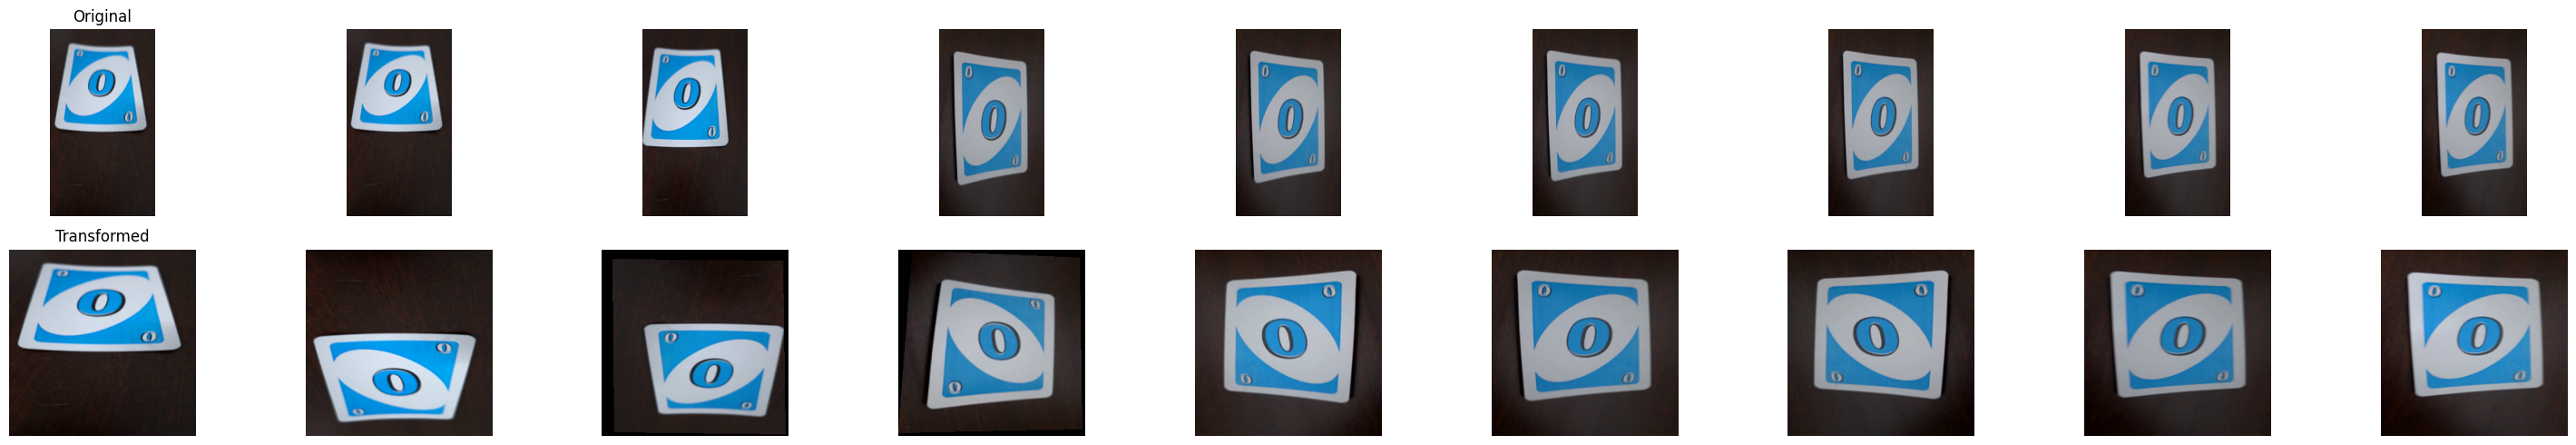

Random samples from dataset with augmentations:


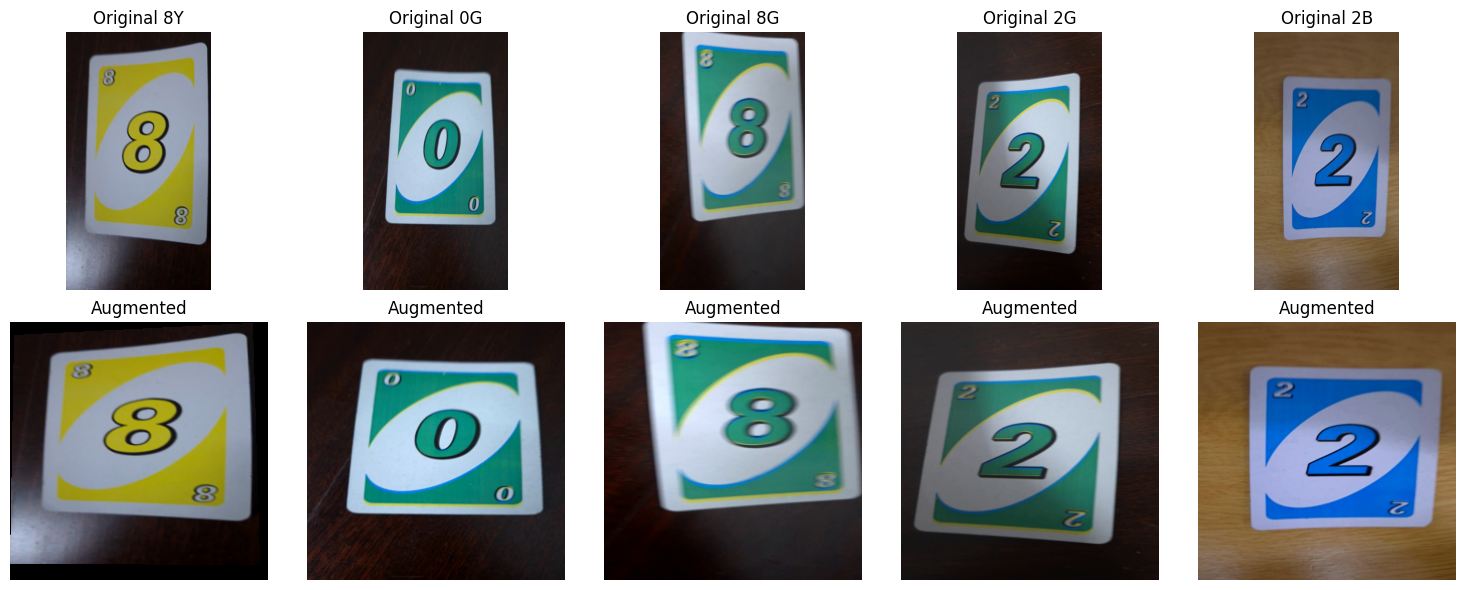


Multiple augmentations of a random 4B card:


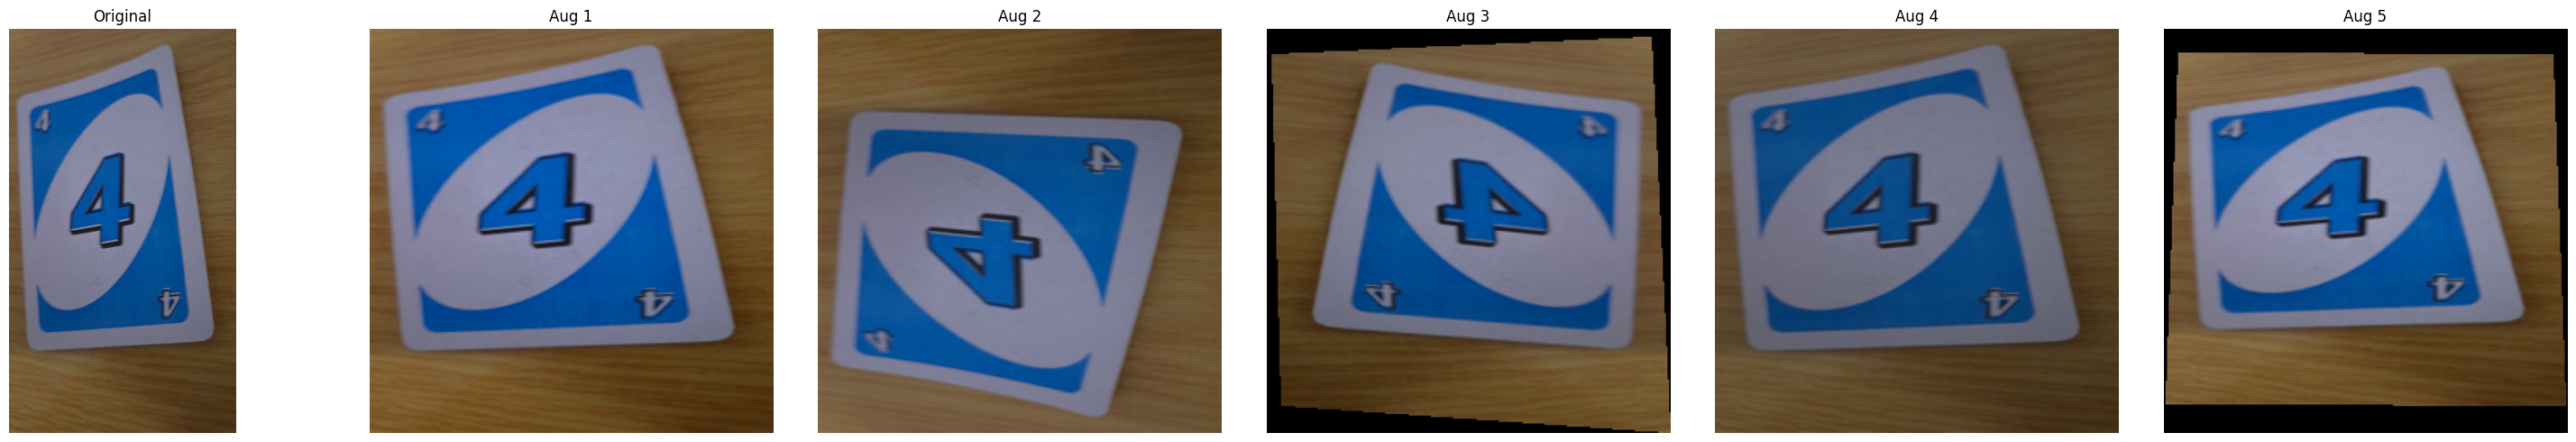

In [14]:
def show_transformed_images(dataset, num_images=9, cols=6):
    """Display original and transformed images side by side"""
    plt.figure(figsize=(30, 5))
    for i in range(num_images):
        # Get an image and its label
        img_path = dataset.samples[i][0]
        original_img = Image.open(img_path).convert('RGB')
        
        # Apply transforms multiple times to see variability
        transformed_img = train_transforms(original_img)
        
        # Convert tensor to image for display
        transformed_img = transformed_img.permute(1, 2, 0)  # Change from CxHxW to HxWxC
        transformed_img = transformed_img * torch.tensor(std) + torch.tensor(mean)  # Denormalize
        transformed_img = torch.clamp(transformed_img, 0, 1)  # Clamp values to valid range
        
        # Plot original and transformed
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_img)
        plt.axis('off')
        if i == 0:
            plt.title('Original')
            
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(transformed_img)
        plt.axis('off')
        if i == 0:
            plt.title('Transformed')
    
    plt.tight_layout()
    plt.show()

# Display sample images
show_transformed_images(full_dataset)

# Show multiple augmentations of same image
def show_multiple_augmentations(dataset, img_index=0, num_augments=5):
    """Show multiple augmentations of the same image"""
    plt.figure(figsize=(30, 5))
    
    # Get original image
    img_path = dataset.samples[img_index][0]
    original_img = Image.open(img_path).convert('RGB')
    
    # Show original
    plt.subplot(1, num_augments + 1, 1)
    plt.imshow(original_img)
    plt.axis('off')
    plt.title('Original')
    
    # Show different augmentations
    for i in range(num_augments):
        transformed_img = train_transforms(original_img)
        transformed_img = transformed_img.permute(1, 2, 0)
        transformed_img = transformed_img * torch.tensor(std) + torch.tensor(mean)
        transformed_img = torch.clamp(transformed_img, 0, 1)
        
        plt.subplot(1, num_augments + 1, i + 2)
        plt.imshow(transformed_img)
        plt.axis('off')
        plt.title(f'Aug {i+1}')
    
    plt.tight_layout()
    plt.show()

def show_random_augmentations(dataset, num_images=5):
    """Display random images before and after augmentation"""
    plt.figure(figsize=(15, 6))
    
    # Get random indices
    indices = torch.randperm(len(dataset))[:num_images]
    
    for idx, i in enumerate(indices):
        # Get an image and its label
        img_path = dataset.samples[i][0]
        original_img = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        transformed_img = train_transforms(original_img)
        
        # Denormalize transformed image
        transformed_img = transformed_img.permute(1, 2, 0)
        transformed_img = transformed_img * torch.tensor(std) + torch.tensor(mean)
        transformed_img = torch.clamp(transformed_img, 0, 1)
        
        # Plot original
        plt.subplot(2, num_images, idx + 1)
        plt.imshow(original_img)
        plt.title(f'Original {dataset.classes[dataset.targets[i]]}')
        plt.axis('off')
        
        # Plot transformed
        plt.subplot(2, num_images, idx + 1 + num_images)
        plt.imshow(transformed_img)
        plt.title('Augmented')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show random images and their augmentations
print("Random samples from dataset with augmentations:")
show_random_augmentations(full_dataset)

# Show multiple augmentations of the same random image
rand_idx = torch.randint(0, len(train_data), (1,)).item()
print(f"\nMultiple augmentations of a random {full_dataset.classes[full_dataset.targets[rand_idx]]} card:")
show_multiple_augmentations(full_dataset, img_index=rand_idx, num_augments=5)

# 4. Building the neural network


In [15]:
# Input shape constants
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [16]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layer
        self.fc = nn.Linear(64, 54)
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [ ]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding='same', bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding='same', bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding='same', bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * (IMG_HEIGHT // 8) * (IMG_WIDTH // 8), 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            nn.Linear(64, 54)
        )
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

In [17]:
model = ConvolutionalNeuralNetwork()
model.to(device)
model = torch.compile(model, backend="inductor")
swa_model = AveragedModel(model)

In [18]:
summary(model, input_size=(64, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [64, 54]                  --
├─ConvolutionalNeuralNetwork: 1-1        [64, 54]                  --
│    └─Sequential: 2-1                   [64, 16, 128, 128]        --
│    │    └─Conv2d: 3-1                  [64, 16, 256, 256]        432
│    │    └─BatchNorm2d: 3-2             [64, 16, 256, 256]        32
│    │    └─ReLU: 3-3                    [64, 16, 256, 256]        --
│    │    └─Conv2d: 3-4                  [64, 16, 256, 256]        2,304
│    │    └─BatchNorm2d: 3-5             [64, 16, 256, 256]        32
│    │    └─ReLU: 3-6                    [64, 16, 256, 256]        --
│    │    └─Conv2d: 3-7                  [64, 16, 256, 256]        2,304
│    │    └─BatchNorm2d: 3-8             [64, 16, 256, 256]        32
│    │    └─ReLU: 3-9                    [64, 16, 256, 256]        --
│    │    └─MaxPool2d: 3-10              [64, 16, 128, 128]        --
│    └─S

# 5. Optimising the model parameters

In [19]:
learning_rate = 1e-5
REG_FACTOR = 2e-4
epochs = 100

In [20]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, fused=True, weight_decay=REG_FACTOR)

In [22]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)

In [23]:
swa_scheduler = SWALR(optimizer, swa_lr=1e-2)
swa_start = 15  # Start SWA after 10 epochs

# 6. Train the model

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    training_loss = 0.0
    correct = 0
    total = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)  # Move data to device

        optimizer.zero_grad()

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * X.size(0)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        total += y.size(0)

        if batch % 100 == 0:
            loss_item = loss.item()
            current = batch * len(X)
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = training_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)  # Move data to device
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)

    avg_loss = test_loss / total
    accuracy = correct / total
    print(f"Avg loss: {avg_loss:>8f}, Accuracy: {(100*accuracy):>0.1f}%\n")

    return avg_loss, accuracy

In [25]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_times = []

best_val_loss = float('inf')
patience = 5  # Number of epochs with no improvement after which training will be stopped
epochs_no_improve = 0
total_start_time = time.time()
stopped_early = False

In [ ]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    epoch_start_time = time.time()

    train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer)

    # Update SWA after swa_start epochs
    if epoch >= swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step(train_loss)  # Use regular scheduler before SWA
        
    val_loss, val_accuracy = test_loop(val_loader, model, loss_fn)

    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")

    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Optionally save the best model
        torch.save(model.state_dict(), '../data/models/best_model.pth')
        torch.save(swa_model.state_dict(), '../data/models/best_swa_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            stopped_early = True
            break

update_bn(train_loader, swa_model, device=device)

total_training_time = time.time() - total_start_time

# Save both models
torch.save(model, '../data/models/final_model.pth')
torch.save(swa_model, '../data/models/final_swa_model.pth')

print(f"\nTraining complete in {total_training_time:.2f} seconds")
print("\n-------------------------------\nDone!")

Epoch 1
-------------------------------
loss: 4.067977  [    0/11522]
loss: 3.914882  [ 6400/11522]
Avg loss: 3.892710, Accuracy: 4.9%

Epoch 1 completed in 105.09 seconds
Training Loss: 3.9800, Training Accuracy: 0.0336
Validation Loss: 3.8927, Validation Accuracy: 0.0489

Epoch 2
-------------------------------
loss: 3.910537  [    0/11522]
loss: 3.888322  [ 6400/11522]
Avg loss: 3.765039, Accuracy: 5.6%

Epoch 2 completed in 100.00 seconds
Training Loss: 3.8206, Training Accuracy: 0.0672
Validation Loss: 3.7650, Validation Accuracy: 0.0562

Epoch 3
-------------------------------
loss: 3.742412  [    0/11522]
loss: 3.725011  [ 6400/11522]
Avg loss: 3.688860, Accuracy: 8.1%

Epoch 3 completed in 158.71 seconds
Training Loss: 3.7207, Training Accuracy: 0.0699
Validation Loss: 3.6889, Validation Accuracy: 0.0811

Epoch 4
-------------------------------
loss: 3.701064  [    0/11522]
loss: 3.663488  [ 6400/11522]
Avg loss: 3.625177, Accuracy: 8.6%

Epoch 4 completed in 197.91 seconds
Tra

# 7. Plot model metrics

In [ ]:
epochs_range = range(1, len(train_losses) + 1)

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Accuracies
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot Epoch Times
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, epoch_times, label='Time per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Time Taken per Epoch')
plt.legend()
plt.show()

# 8. Test the model

In [ ]:
# Load and prepare SWA model
swa_model = torch.load('../data/models/final_swa_model.pth')
swa_model.to(device)
swa_model.eval()

print("Test Results using SWA model:")
test_loss, test_accuracy = test_loop(test_loader, swa_model, loss_fn)

In [ ]:
model = ConvolutionalNeuralNetwork()
model.to(device)
model = torch.compile(model, backend="inductor")

# Load the best model (if saved during early stopping)
if stopped_early:
    model.load_state_dict(torch.load('../data/models/best_model.pth'))
else:
    model = torch.load('../data/models/full_model.pth')

model.eval()

print("Test Results on the Test Set:")
test_loop(test_loader, model, loss_fn)

In [ ]:
image_transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomAdjustSharpness(sharpness_factor=1.5, p=1.0),  # Subtle sharpness changes
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

In [ ]:
# Load and preprocess the image
image_path = 'test_image.jpg' 
image = Image.open(image_path).convert('RGB')
input_tensor = image_transform(image)
input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.to(device)

In [ ]:
# Make prediction
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = output.argmax(dim=1).item()

In [ ]:
# Get class names
class_names = train_dataset.classes
predicted_label = class_names[predicted_class]
print(f"Predicted class: {predicted_label}")